In [44]:
import sys
sys.path.append('../..')
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch as ch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Gumbel
import math
import numpy as np
import matplotlib.pyplot as plt
import cox
from cox.utils import Parameters
import cox.store as store
from cox.readers import CollectionReader
import seaborn as sns
import os
import config

from delphi import train
from delphi.cifar_models import vgg11
from delphi.utils import model_utils
from delphi import grad
from delphi import oracle
from delphi.utils.datasets import CIFAR, ImageNet
import delphi.utils.constants as consts
import delphi.utils.data_augmentation as da
from delphi.utils.helpers import setup_store_with_metadata
import pickle
import pandas as pd

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# noise distributions
gumbel = Gumbel(0, 1)
num_classes = 10

# file path constants
BASE_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/base_calibrated_'
BASE_CLASSIFIER_PATH = BASE_CLASSIFIER + '/6800833c-3d58-46c0-8260-951434b58112/checkpoint.pt.latest'
PRETRAINED_MODEL = '/home/pstefanou/cifar-10/resnet-18/new_pre_train_'
LOGIT_BALL_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/truncated_calibrated_'
STANDARD_CLASSIFIER = '/home/pstefanou/cifar-10/resnet-18/standard_calibrated_'
DATA_PATH = '/home/pstefanou/data/'
TRUNC_TRAIN_DATASET = 'trunc_train_calibrated_logit__'
TRUNC_VAL_DATASET = 'trunc_val_calibrated_logit__'
TRUNC_TEST_DATASET = 'trunc_test_calibrated_logit__'

# helper dataset
class TruncatedCIFAR(Dataset):
    """
    Truncated CIFAR-10 dataset [Kri09]_.
    Original dataset has 50k training images and 10k testing images, with the
    following classes:
    * Airplane
    * Automobile
    * Bird
    * Cat
    * Deer
    * Dog
    * Frog
    * Horse
    * Ship
    * Truck
    .. [Kri09] Krizhevsky, A (2009). Learning Multiple Layers of Features
        from Tiny Images. Technical Report.
        
    Truncated dataset only includes images and labels from original dataset that fall within the truncation set.
    """
    def __init__(self, img, label, transform = None):
        """
        """
        self.img = img 
        self.label = label
        self.transform = transform

    def __getitem__(self, idx):
        """
        """
        x = self.img[idx]
        y = self.label[idx]
        # data augmentation
        if self.transform: 
            x = self.transform(x)
            
        return x, y
    
    def __len__(self): 
        return self.img.size(0)
transform_ = transforms.Compose(
    [transforms.ToTensor()])

# hyperparameters
args = Parameters({ 
    'epochs': 25,
    'workers': 8, 
    'batch_size': 128, 
    'lr': 1e-1, 
    'accuracy': True,
    'momentum': 0.9, 
    'weight_decay': 0.0, 
    'save_ckpt_iters': 50,
    'should_save_ckpt': True,
    'log_iters': 1,
    'custom_lr_multiplier': consts.CYCLIC, 
    'validation_split': .8,
    'shuffle': True,
    'parallel': False, 
    'num_samples': 1000,
    'logit_ball': 10.0,
    'trials': 5,
    'step_lr': 10, 
    'step_lr_gamma': 1.0,
    'weight_decay': 5e-4, 
    'temperature': nn.Parameter(ch.ones(1).cuda()),
    'device': 'cuda' if ch.cuda.is_available() else 'cpu'
})

# Setup and Explore Dataset

In [3]:
ds = CIFAR(data_path='/home/pstefanou/')
# train_loader, val_loader = ds.make_loaders(batch_size=128, workers=8, data_aug=False)

In [4]:
import torchvision 
dataset = torchvision.datasets.CIFAR10(root='/home/pstefanou/', train=True,
                                        download=False, transform=transform_)

train_set, val_set = ch.utils.data.random_split(dataset, [45000, 5000])

train_loader = ch.utils.data.DataLoader(train_set, batch_size=128,
                                          shuffle=True, num_workers=2)

val_loader = ch.utils.data.DataLoader(val_set, batch_size=128,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='/home/pstefanou/', train=False,
                                       download=False, transform=transform_)
test_loader = ch.utils.data.DataLoader(test_set, batch_size=128,
                                         shuffle=False, num_workers=2)

label: frog


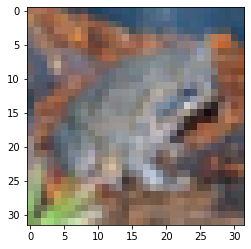

label: ship


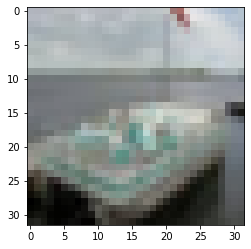

label: bird


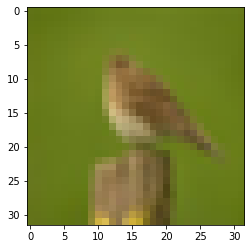

label: dog


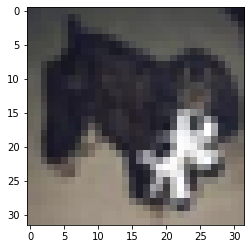

label: cat


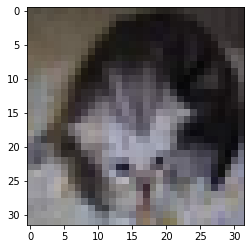

label: truck


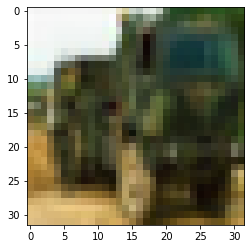

label: horse


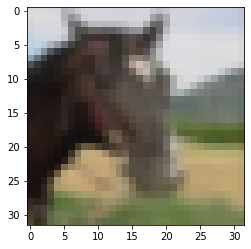

label: airplane


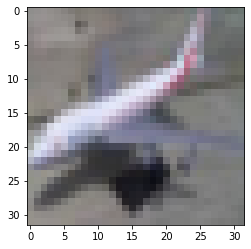

label: deer


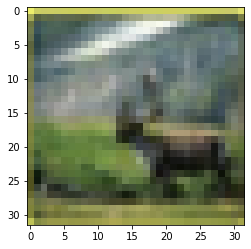

label: automobile


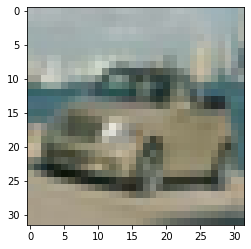

In [5]:
labels = {i for i in range(10)}
for image, target in train_loader: 
    for j in range(len(target)): 
        im, targ = image[j], target[j]
        if targ.item() in labels: 
            print("label: {}".format(da.CIFAR_LABELS[targ.item()]))
            plt.imshow(transforms.ToPILImage(mode="RGB")(im.squeeze(0)))
            plt.show()
            labels.remove(targ.item())
        if len(labels) == 0: 
            break

# Train Base Classifier

In [12]:
base_classifier, base_sd = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
out_store = store.Store(BASE_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/base_calibrated_/6800833c-3d58-46c0-8260-951434b58112


In [13]:
# train
ch.manual_seed(0)
train.train_model(args, base_classifier, (train_loader, val_loader), store=out_store)
out_store.close()

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [14]:
reader = CollectionReader(BASE_CLASSIFIER)
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 2/2 [00:00<00:00, 212.21it/s]


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,10.120000,2.367606,9.915556,2.361091,22.825660,bcbc1ae1-9164-40c3-b6aa-397c46f9d7fe
1,2,33.879997,1.764393,24.013334,2.316112,45.349004,bcbc1ae1-9164-40c3-b6aa-397c46f9d7fe
2,3,47.160000,1.448877,41.817780,1.591888,68.033942,bcbc1ae1-9164-40c3-b6aa-397c46f9d7fe
3,4,51.180000,1.442712,52.951111,1.296110,90.799535,bcbc1ae1-9164-40c3-b6aa-397c46f9d7fe
4,5,63.199997,1.025935,62.111111,1.055269,113.580213,bcbc1ae1-9164-40c3-b6aa-397c46f9d7fe


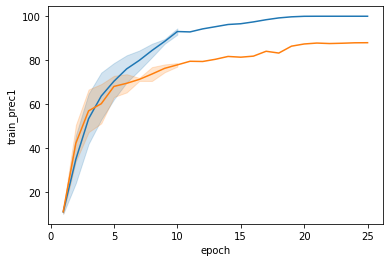

<AxesSubplot:xlabel='epoch', ylabel='train_loss'>

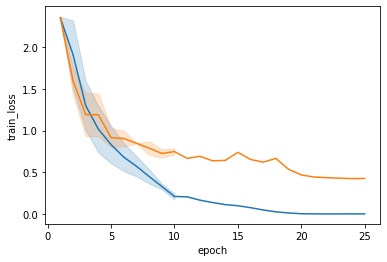

In [15]:
sns.lineplot(data=logs, x='epoch', y='train_prec1')
sns.lineplot(data=logs, x='epoch', y='val_prec1')
plt.show()
sns.lineplot(data=logs, x='epoch', y='train_loss')
sns.lineplot(data=logs, x='epoch', y='val_loss')

# Truncate CIFAR-10

In [18]:
base_classifier = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=BASE_CLASSIFIER_PATH)[0]

=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/base_calibrated_/6800833c-3d58-46c0-8260-951434b58112/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/base_calibrated_/6800833c-3d58-46c0-8260-951434b58112/checkpoint.pt.latest' (epoch 25)


# Callibrate Base Classifier

In [25]:
from tqdm.notebook import tqdm

def T_scaling(logits, temp):
    return ch.div(logits, temp)

# Use kwargs for calibration method specific parameters
def test(calibration_method=None):
    preds = []
    labels_oneh = []
    correct = 0
    base_classifier.eval()
    with ch.no_grad():
        for data in tqdm(test_loader):
            images, labels = data[0].to('cuda:0'), data[1].to('cuda:0')

            pred = base_classifier(images)[0]

            if calibration_method:
                pred = calibration_method(pred, args.temperature.item())

            # Get softmax values for net input and resulting class predictions
            sm = nn.Softmax(dim=1)
            pred = sm(pred)

            _, predicted_cl = ch.max(pred.data, 1)
            pred = pred.cpu().detach().numpy()

            # Convert labels to one hot encoding
            label_oneh = ch.nn.functional.one_hot(labels, num_classes=num_classes)
            label_oneh = label_oneh.cpu().detach().numpy()

            preds.extend(pred)
            labels_oneh.extend(label_oneh)

            # Count correctly classified samples for accuracy
            correct += sum(predicted_cl == labels).item()

    preds = np.array(preds).flatten()
    labels_oneh = np.array(labels_oneh).flatten()

    correct_perc = correct / len(test_loader.dataset)
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct_perc))
    print(correct_perc)

    return preds, labels_oneh

preds, labels_oneh = test()

def calc_bins(preds):
    # Assign each prediction to a bin
    num_bins = 10
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(preds, bins)

    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(preds[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (labels_oneh[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]

    return bins, binned, bin_accs, bin_confs, bin_sizes

def get_metrics(preds):
    ECE = 0
    MCE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds)

    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        MCE = max(MCE, abs_conf_dif)

    return ECE, MCE


import matplotlib.patches as mpatches

def draw_reliability_graph(preds):
    ECE, MCE = get_metrics(preds)
    bins, _, bin_accs, _, _ = calc_bins(preds)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()

    # x/y limits
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

    # x/y labels
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')

    # Create grid
    ax.set_axisbelow(True) 
    ax.grid(color='gray', linestyle='dashed')

    # Error bars
    plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

    # Draw bars and identity line
    plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
    plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

    # Equally spaced axes
    plt.gca().set_aspect('equal', adjustable='box')

    # ECE and MCE legend
    ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
    MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
    plt.legend(handles=[ECE_patch, MCE_patch])

    #plt.show()

    plt.savefig('calibrated_network.png', bbox_inches='tight')

#draw_reliability_graph(preds)


  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87 %
0.8721


  0%|          | 0/40 [00:00<?, ?it/s]

Final T_scaling factor: 1.43


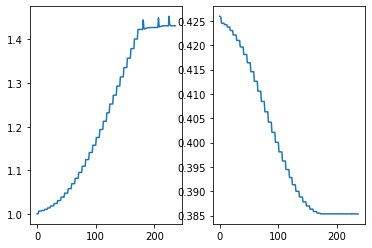

In [20]:
criterion = nn.CrossEntropyLoss()

# Removing strong_wolfe line search results in jump after 50 epochs
optimizer = ch.optim.LBFGS([args.temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

logits_list = []
labels_list = []
temps = []
losses = []

for i, data in enumerate(tqdm(val_loader, 0)):
    images, labels = data[0].cuda(), data[1].cuda()

    base_classifier.eval()
    with ch.no_grad():
        logits_list.append(base_classifier(images)[0])
        labels_list.append(labels)

# Create tensors
logits_list = ch.cat(logits_list).cuda()
labels_list = ch.cat(labels_list).cuda()

def _eval():
    loss = criterion(T_scaling(logits_list, args.temperature), labels_list)
    loss.backward()
    temps.append(args.temperature.item())
    losses.append(loss)
    return loss


optimizer.step(_eval)

print('Final T_scaling factor: {:.2f}'.format(args.temperature.item()))

plt.subplot(121)
plt.plot(list(range(len(temps))), temps)

plt.subplot(122)
plt.plot(list(range(len(losses))), losses)
plt.show()

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87 %
0.8721


  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87 %
0.8721


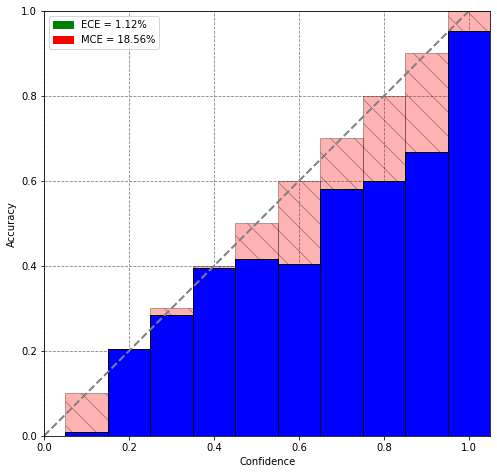

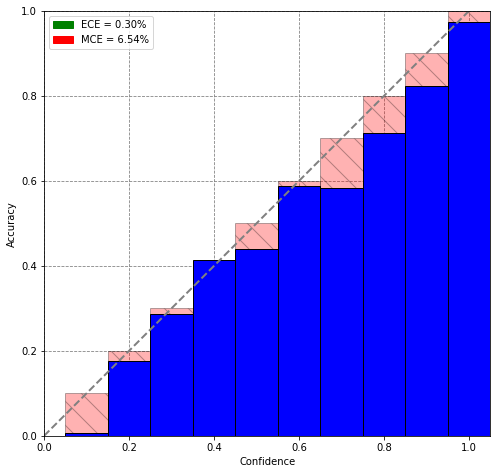

In [27]:
preds_original, _ = test()
preds_calibrated, _ = test(T_scaling)

draw_reliability_graph(preds_original)
draw_reliability_graph(preds_calibrated)

In [29]:
orig_ece, orig_mce = get_metrics(preds_original)
calibrated_ece, calibrated_mce = get_metrics(preds_calibrated)

print("original ece: ", orig_ece)
print("original mce: ", orig_mce)

print("calibrated ece: ", calibrated_ece)
print("calibrated mce: ", calibrated_mce)

original ece:  0.011211884174829883
original mce:  0.18564385308159725
calibrated ece:  0.0029660571289062522
calibrated mce:  0.06542890832779258


In [48]:
# membership oracle
phi = oracle.LogitBallComplement(args.logit_ball)

# check if there exists a cifar 10 train truncated dataset already
if True or not os.path.isfile(DATA_PATH + TRUNC_TRAIN_DATASET + str(args.logit_ball) + '.pickle') or not os.path.isfile(DATA_PATH + TRUNC_TRAIN_DATASET + str(args.logit_ball) + '.pickle'):
    trunc_train_X, trunc_train_y = Tensor([]), Tensor([])
    # unseen test data
    trunc_test_X, trunc_test_y = Tensor([]), Tensor([])
    for inp, targ in train_loader: 
        inp, targ = inp.to(args.device), targ.to(args.device)
        logits, inp = base_classifier(inp)
        logits = T_scaling(logits, args.temperature.item())
        # add gumbel noise to the logits
        noised = logits.cpu() + gumbel.sample(logits.size())
        filtered = phi(noised)
        indices = filtered.nonzero(as_tuple=False).flatten()
        test_indices = (~filtered).nonzero(as_tuple=False).flatten()
        trunc_train_X, trunc_train_y = ch.cat([trunc_train_X, inp[indices].cpu()]), ch.cat([trunc_train_y, targ[indices].cpu()])
        trunc_test_X, trunc_test_y = ch.cat([trunc_test_X, inp[test_indices].cpu()]), ch.cat([trunc_test_y, targ[test_indices].cpu()])

    print("train alpha: ", trunc_train_X.size(0) / len(train_loader.dataset))
    trunc_train_loader = DataLoader(TruncatedCIFAR(trunc_train_X, trunc_train_y.long(), transform= None), num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)

    # train loader
    with open(DATA_PATH + TRUNC_TRAIN_DATASET + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_train_loader, f)
else:  
    trunc_train_loader = pd.read_pickle(DATA_PATH + TRUNC_TRAIN_DATASET + str(args.logit_ball) + '.pickle')
trunc_train_loader

train alpha:  0.7957777777777778


In [50]:
# check if there exists a cifar 10 valdation and test truncated dataset
if True or not os.path.isfile(DATA_PATH + TRUNC_VAL_DATASET + str(args.logit_ball) + '.pickle') or not os.path.isfile(DATA_PATH + TRUNC_VAL_DATASET + str(args.logit_ball) + '.pickle'):
    trunc_val_X, trunc_val_y = Tensor([]), Tensor([]) 

    for inp, targ in val_loader: 
        inp, targ = inp.to(args.device), targ.to(args.device)
        logits, inp = base_classifier(inp)
        logits = T_scaling(logits, args.temperature.item())
        # add gumbel noise to the logits
        noised = logits.cpu() + gumbel.sample(logits.size())
        filtered = phi(noised)
        indices = filtered.nonzero(as_tuple=False).flatten()
        test_indices = (~filtered).nonzero(as_tuple=False).flatten()
        trunc_val_X, trunc_val_y = ch.cat([trunc_val_X, inp[indices].cpu()]), ch.cat([trunc_val_y, targ[indices].cpu()])
        trunc_test_X, trunc_test_y = ch.cat([trunc_test_X, inp[test_indices].cpu()]), ch.cat([trunc_test_y, targ[test_indices].cpu()])

    print("val alpha: ", trunc_val_X.size(0) / len(val_loader.dataset))
    trunc_val_loader = DataLoader(TruncatedCIFAR(trunc_val_X, trunc_val_y.long(), transform=None), num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)
    # truncated test set (unseen data that the model has not been tested on)
    trunc_test_loader = DataLoader(TruncatedCIFAR(trunc_test_X, trunc_test_y.long(), transform=None), 
                             num_workers=args.workers, shuffle=args.shuffle, batch_size=args.batch_size)

    # validation loader
    with open(DATA_PATH + TRUNC_VAL_DATASET + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_val_loader, f)

    # test loader
    with open(DATA_PATH + TRUNC_TEST_DATASET + str(args.logit_ball) + '.pickle', 'wb') as f: 
        pickle.dump(trunc_test_loader, f)
else: 
    trunc_val_loader = pd.read_pickle(DATA_PATH + TRUNC_VAL_DATASET + str(args.logit_ball) + '.pickle')
    trunc_test_loader = pd.read_pickle(DATA_PATH + TRUNC_TEST_DATASET + str(args.logit_ball) + '.pickle')
trunc_val_loader, trunc_test_loader

val alpha:  0.6058


(<torch.utils.data.dataloader.DataLoader at 0x7ff71c0809e8>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff56d522e80>)

In [51]:
print("alpha train: ", len(trunc_train_loader.dataset) / len(train_loader.dataset))
print("alpha val: ", len(trunc_val_loader.dataset) / len(val_loader.dataset))
print("test set size: ", len(trunc_test_loader.dataset))

alpha train:  0.7957777777777778
alpha val:  0.6058
test set size:  11161


# Setup Store and Pretrain Model

In [52]:
pretrained_model, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
# logging store
out_store = store.Store(PRETRAINED_MODEL)
setup_store_with_metadata(args, out_store)
args.__setattr__('custom_criterion', None)

Logging in: /home/pstefanou/cifar-10/resnet-18/new_pre_train_/3afb48b5-6ba0-4c33-8d41-69db0afff722


# Start by Training Pretrainig a Standard Classifier

In [53]:
# train
ch.manual_seed(0)
args.__setattr__('epochs', 2)
pretrained_model = train.train_model(args, pretrained_model, (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)

# evaluate model on train, validation, and unseen datasets
test_set_results = train.eval_model(args, pretrained_model, trunc_test_loader, out_store)
print("pretrained model test set results: ", test_set_results)
train_set_results = train.eval_model(args, pretrained_model, trunc_train_loader, out_store)
print("pretrained model train set results: ", train_set_results)
val_set_results = train.eval_model(args, pretrained_model, trunc_val_loader, out_store) 
print("pretrained model val set results: ", val_set_results)

out_store.close()

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

pretrained model test set results:  {'test_prec1': tensor(37.2547, device='cuda:0'), 'test_loss': 1.7554175393169749, 'time': 2.401726484298706}


  0%|          | 0/280 [00:00<?, ?it/s]

pretrained model train set results:  {'test_prec1': tensor(52.6361, device='cuda:0'), 'test_loss': 1.3058193451796987, 'time': 5.937986612319946}


  0%|          | 0/24 [00:00<?, ?it/s]

pretrained model val set results:  {'test_prec1': tensor(58.0059, device='cuda:0'), 'test_loss': 1.1687714353021752, 'time': 1.212510347366333}


In [54]:
reader = CollectionReader(PRETRAINED_MODEL)
metadata = reader.df('metadata')
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 1/1 [00:00<00:00, 55.32it/s]


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,44.602177,1.469772,30.069813,2.049093,19.158874,3afb48b5-6ba0-4c33-8d41-69db0afff722
1,2,58.005939,1.168771,49.304661,1.388533,38.334944,3afb48b5-6ba0-4c33-8d41-69db0afff722


# Plot Standard Trained Classifier Loss and Accuracy Curves

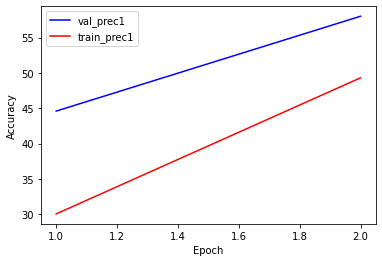

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

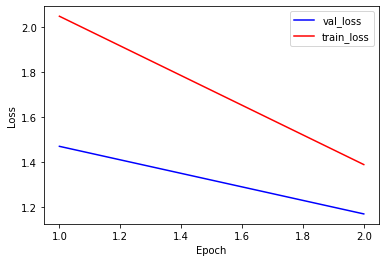

In [55]:
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val_prec1', color='b')
ax = sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train_prec1', color='r')
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

sns.lineplot(data=logs, x='epoch', y='val_loss', label='val_loss', color='b')
ax = sns.lineplot(data=logs, x='epoch', y='train_loss', label='train_loss', color='r')
ax.set(xlabel='Epoch', ylabel='Loss')

# Train Rest of Pretrained Model Using Truncated CE Loss

In [62]:
##### logging store
out_store = store.Store(LOGIT_BALL_CLASSIFIER)
setup_store_with_metadata(args, out_store)
# load in previously trained classifer to run truncated gradient against it
delphi_ =  model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=PRETRAINED_MODEL + '/3afb48b5-6ba0-4c33-8d41-69db0afff722/checkpoint.pt.latest')
# set oracle
args.__setattr__('phi', phi)
# set gradient 
args.__setattr__('custom_criterion', grad.TruncatedCE.apply)

Logging in: /home/pstefanou/cifar-10/resnet-18/truncated_calibrated_/f970cc21-8e91-4664-9bfc-ecf92973cc56
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/new_pre_train_/3afb48b5-6ba0-4c33-8d41-69db0afff722/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/new_pre_train_/3afb48b5-6ba0-4c33-8d41-69db0afff722/checkpoint.pt.latest' (epoch 2)


Sanity check to make sure that we loader in the correct model

In [57]:
train.eval_model(args, delphi_[0], trunc_test_loader, out_store)

  0%|          | 0/88 [00:00<?, ?it/s]

{'test_prec1': tensor(37.2547, device='cuda:0'),
 'test_loss': 1.7554175428630268,
 'time': 2.3958029747009277}

# TruncatedCE with Logit Ball Oracle

In [58]:
# train
ch.manual_seed(0)
args.__setattr__('epochs', 10)
config.args = args
final_model = train.train_model(args, delphi_[0], (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)
out_store.close()

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [68]:
reader = CollectionReader(LOGIT_BALL_CLASSIFIER)
metadata = reader.df('metadata')
trunc_logs = reader.df('logs')
reader.close()
trunc_logs

100%|██████████| 1/1 [00:00<00:00, 59.16it/s]


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,59.194450,1.112029,54.222282,1.263063,19.137777,b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4
1,2,66.259491,0.965769,55.437027,1.222552,38.033020,b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4
2,3,69.527893,0.848116,59.084053,1.138568,56.921664,b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4
3,4,76.427864,0.656406,68.550682,0.882426,75.826138,b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4
4,5,81.082863,0.558017,75.302986,0.696801,94.807090,b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4
5,6,80.785736,0.554316,80.080978,0.562825,113.794624,b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4
6,7,81.313965,0.557431,85.210831,0.421489,132.727879,b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4
7,8,86.365135,0.413853,90.000000,0.283827,151.636516,b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4
8,9,87.751732,0.390203,95.400726,0.140537,170.585183,b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4
9,10,89.930664,0.367050,99.039375,0.044171,189.947354,b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4


In [60]:
trunc_logs = trunc_logs[trunc_logs['exp_id'] == 'c8623884-2366-4c90-8a75-a1e012c11300']

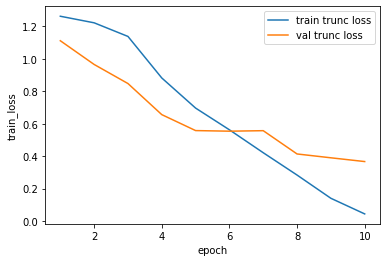

<AxesSubplot:xlabel='epoch', ylabel='train_prec1'>

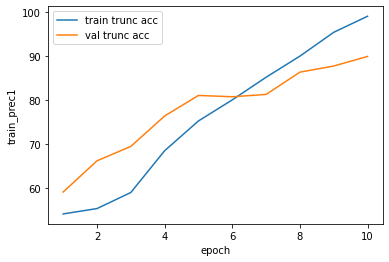

In [69]:
sns.lineplot(data=trunc_logs, x='epoch', y='train_loss', label='train trunc loss')
sns.lineplot(data=trunc_logs, x='epoch', y='val_loss', label='val trunc loss')

# sns.lineplot(data=logs, x='epoch', y='train_loss', label='train loss')
# sns.lineplot(data=logs, x='epoch', y='val_loss', label='val loss')
plt.show()

sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', label='train trunc acc')
sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', label='val trunc acc')

# sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train acc')
# sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val acc')

# Train Model on Standard CE Loss with Truncated Dataset

In [63]:
##### logging store
out_store = store.Store(STANDARD_CLASSIFIER)
setup_store_with_metadata(args, out_store)
# load in previously trained classifer to run truncated gradient against it
standard =  model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=PRETRAINED_MODEL + '/3afb48b5-6ba0-4c33-8d41-69db0afff722/checkpoint.pt.latest')
# set oracle
args.__setattr__('phi', None)
# set gradient 
args.__setattr__('custom_criterion', None)
# decrease learning rate
args.__setattr__('lr', 1e-1)

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_calibrated_/d52abf5e-dfc2-4569-b119-30020b7774e0
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/new_pre_train_/3afb48b5-6ba0-4c33-8d41-69db0afff722/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/new_pre_train_/3afb48b5-6ba0-4c33-8d41-69db0afff722/checkpoint.pt.latest' (epoch 2)


In [64]:
# train
ch.manual_seed(0)
args.__setattr__('epochs', 10)
config.args = args
final_model = train.train_model(args, standard[0], (trunc_train_loader, trunc_val_loader), store=out_store, parallel=args.parallel)
out_store.close()

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [65]:
reader = CollectionReader(STANDARD_CLASSIFIER)
metadata = reader.df('metadata')
logs = reader.df('logs')
reader.close()
logs

100%|██████████| 1/1 [00:00<00:00, 87.48it/s]


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,59.194450,1.112029,54.222282,1.263063,19.193414,d52abf5e-dfc2-4569-b119-30020b7774e0
1,2,64.839882,0.993903,55.470539,1.222762,38.181926,d52abf5e-dfc2-4569-b119-30020b7774e0
2,3,69.428848,0.870669,58.704269,1.148149,57.120841,d52abf5e-dfc2-4569-b119-30020b7774e0
3,4,77.781441,0.631484,68.857857,0.879232,76.037490,d52abf5e-dfc2-4569-b119-30020b7774e0
4,5,81.644104,0.545588,75.297401,0.699742,94.934177,d52abf5e-dfc2-4569-b119-30020b7774e0
5,6,80.059425,0.568797,80.321136,0.560293,113.907126,d52abf5e-dfc2-4569-b119-30020b7774e0
6,7,84.351265,0.472789,85.177322,0.421682,132.894095,d52abf5e-dfc2-4569-b119-30020b7774e0
7,8,85.704849,0.427846,90.164757,0.280239,151.840356,d52abf5e-dfc2-4569-b119-30020b7774e0
8,9,88.114883,0.397494,95.386765,0.139841,170.882334,d52abf5e-dfc2-4569-b119-30020b7774e0
9,10,88.874214,0.364740,99.014236,0.044688,190.299027,d52abf5e-dfc2-4569-b119-30020b7774e0


In [554]:
logs = logs[logs['exp_id'] == '384aaa4b-a6d4-4824-b8bc-de1b178dac19']

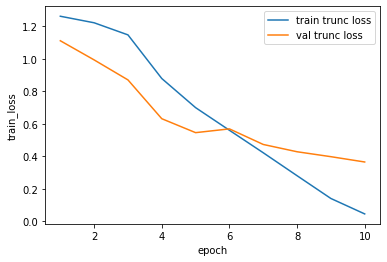

<AxesSubplot:xlabel='epoch', ylabel='train_prec1'>

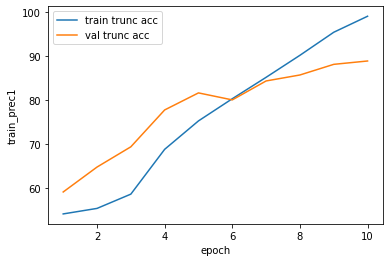

In [66]:
sns.lineplot(data=logs, x='epoch', y='train_loss', label='train trunc loss')
sns.lineplot(data=logs, x='epoch', y='val_loss', label='val trunc loss')
plt.show()

sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train trunc acc')
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val trunc acc')

# Load Trained Models into Notebook

In [71]:
base = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=BASE_CLASSIFIER_PATH)
delphi_ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=LOGIT_BALL_CLASSIFIER + '/b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4/checkpoint.pt.latest')
standard_model =  model_utils.make_and_restore_model(arch='resnet18', dataset=ds, resume_path=STANDARD_CLASSIFIER + '/d52abf5e-dfc2-4569-b119-30020b7774e0/checkpoint.pt.latest')

=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/base_calibrated_/6800833c-3d58-46c0-8260-951434b58112/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/base_calibrated_/6800833c-3d58-46c0-8260-951434b58112/checkpoint.pt.latest' (epoch 25)
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/truncated_calibrated_/b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/truncated_calibrated_/b8a9b7b2-ac7d-4a9c-aee3-285205bb11d4/checkpoint.pt.latest' (epoch 10)
=> loading checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_calibrated_/d52abf5e-dfc2-4569-b119-30020b7774e0/checkpoint.pt.latest'
=> loaded checkpoint '/home/pstefanou/cifar-10/resnet-18/standard_calibrated_/d52abf5e-dfc2-4569-b119-30020b7774e0/checkpoint.pt.latest' (epoch 10)


# Test Accuracy

In [72]:
delphi_store = store.Store(LOGIT_BALL_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/truncated_calibrated_/be1d3961-a802-4f14-9c92-2532ab0e6221


In [73]:
delphi_test_results = train.eval_model(args, delphi_[0], trunc_test_loader, delphi_store)
print("delphi test results: ", delphi_test_results)

delphi_train_results = train.eval_model(args, delphi_[0], trunc_train_loader, delphi_store)
print("delphi train results: ", delphi_train_results)

delphi_val_results = train.eval_model(args, delphi_[0], trunc_val_loader, delphi_store)
print("delphi val results: ", delphi_val_results)
delphi_store.close()

  0%|          | 0/88 [00:00<?, ?it/s]

delphi test results:  {'test_prec1': tensor(67.3058, device='cuda:0'), 'test_loss': 1.1836213608837376, 'time': 2.423978805541992}


  0%|          | 0/280 [00:00<?, ?it/s]

delphi train results:  {'test_prec1': tensor(99.8743, device='cuda:0'), 'test_loss': 0.014849142582618435, 'time': 5.955229043960571}


  0%|          | 0/24 [00:00<?, ?it/s]

delphi val results:  {'test_prec1': tensor(89.9307, device='cuda:0'), 'test_loss': 0.3670504540450977, 'time': 1.2813317775726318}


In [74]:
base_store = store.Store(BASE_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/base_calibrated_/da500f8c-e5c8-4cdb-bfeb-dfde16d45214


In [75]:
base_test_results = train.eval_model(args, base[0], trunc_test_loader, base_store)
print("base test results: ", base_test_results)

base_train_results = train.eval_model(args, base[0], trunc_train_loader, base_store)
print("base train results: ", base_train_results)

base_val_results = train.eval_model(args, base[0], trunc_val_loader, base_store)
print("base val results: ", base_val_results)
base_store.close()

  0%|          | 0/88 [00:00<?, ?it/s]

base test results:  {'test_prec1': tensor(95.7799, device='cuda:0'), 'test_loss': 0.14086630453188972, 'time': 2.3785130977630615}


  0%|          | 0/280 [00:00<?, ?it/s]

base train results:  {'test_prec1': tensor(100., device='cuda:0'), 'test_loss': 0.0006568464315039956, 'time': 5.743766784667969}


  0%|          | 0/24 [00:00<?, ?it/s]

base val results:  {'test_prec1': tensor(95.6421, device='cuda:0'), 'test_loss': 0.1919973608230592, 'time': 1.2209854125976562}


In [76]:
standard_store = store.Store(STANDARD_CLASSIFIER)

Logging in: /home/pstefanou/cifar-10/resnet-18/standard_calibrated_/2fafbd21-ba1e-4516-8d4e-c53c657bcae2


In [77]:
standard_test_results = train.eval_model(args, standard_model[0], trunc_test_loader, standard_store)
print("standard test results: ", standard_test_results)

standard_train_results = train.eval_model(args, standard_model[0], trunc_train_loader, standard_store)
print("standard train results: ", standard_train_results)

standard_val_results = train.eval_model(args, standard_model[0], trunc_val_loader, standard_store)
print("standard val results: ", standard_val_results)
standard_store.close()

  0%|          | 0/88 [00:00<?, ?it/s]

standard test results:  {'test_prec1': tensor(67.3506, device='cuda:0'), 'test_loss': 1.1923358175086138, 'time': 2.4418797492980957}


  0%|          | 0/280 [00:00<?, ?it/s]

standard train results:  {'test_prec1': tensor(99.8241, device='cuda:0'), 'test_loss': 0.01570464707109989, 'time': 5.961580514907837}


  0%|          | 0/24 [00:00<?, ?it/s]

standard val results:  {'test_prec1': tensor(88.8742, device='cuda:0'), 'test_loss': 0.3647395317193973, 'time': 1.2089099884033203}
